Load Data

In [13]:
import pandas as pd

df = pd.read_excel("review_data.xlsx")

print(df.shape)
df = df.dropna() #Drop null rows to not deal with them in this step
print(df.shape)

reviews = df["Review"]
opinion = df["Liked"]

print(reviews[0])
print(opinion[0])

df.head()

(1000, 2)
(997, 2)
Wow... Loved this place.
1


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Handle Not

In [14]:
def handle_not(line:list):
   for token,i in zip(line,range(0,len(line))):
         if token == "not":
            if line[i+1] != None:
               if (line[i+1] == "good"):
                  line[i+1] = "bad"
               elif (line[i+1] == "bad"):
                  line[i+1] = "good"
               elif (line[i+1] == "tasty"):
                  line[i+1] = "bland"
               elif (line[i+1] == "bland"):
                  line[i+1] = "tasty"
               elif (line[i+1] == "inspired"):
                  line[i+1] = "uninspired"
               elif (line[i+1] == "like"):
                  line[i+1] = "dislike"
               elif (line[i+1] == "worth"):
                  line[i+1] = "unworth"
               elif (line[i+1] == "lacking"):
                  line[i+1] = "sufficent"
               elif (line[i+1] == "sure"):
                  line[i+1] = "unsure"
               elif (line[i+1] == "pleasant"):
                  line[i+1] = "unpleasant"
               elif (line[i+1] == "impressed"):
                  line[i+1] = "unimpressed"
               elif (line[i+1] == "attentive"):
                  line[i+1] = "unattentive"
               elif (line[i+1] == "edible"):
                  line[i+1] = "inedible"
               elif (line[i+1] == "thick"):
                  line[i+1] = "thin"
               elif (line[i+1] == "clean"):
                  line[i+1] = "dirty"
               elif (line[i+1] == "consistent"):
                  line[i+1] = "inconsistent"
               elif (line[i+1] == "love"):
                  line[i+1] = "hate"
               elif (line[i+1] == "hate"):
                  line[i+1] = "love"
   return line

Preprocessing

In [15]:
import string
from tkinter import W
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

sentence_all = list()
lines = reviews.to_list()

#lines = ["Program programmer AND Programming ... programmed"]

for line in lines:
    tokens = word_tokenize(line) #TOKENIZATION
    tokens = [w.lower() for w in tokens] #TO LOWERCASE
    table = str.maketrans('','',string.punctuation) #PUNCTUATION REMOVAL
    stripped = [w.translate(table) for w in tokens] #STRIPPING
    words = [word for word in stripped if word.isalpha()] #STRIPPING

    words = handle_not(words)

    stop_words = set(stopwords.words("english")) #STOPWORD REMOVAL
    words = [w for w in words if not w in stop_words] #STOPWORD REMOVAL

    for w,i in zip(words,range(0,len(words))): #Stemming
        w = PorterStemmer().stem(w)
        words[i] = w

    sentence_all.append(words)

print(reviews[0]," >> ",sentence_all[0])
print(reviews[1]," >> ",sentence_all[1])
print(reviews[2]," >> ",sentence_all[2])

Wow... Loved this place.  >>  ['wow', 'love', 'place']
Crust is not good.  >>  ['crust', 'bad']
Not tasty and the texture was just nasty.  >>  ['bland', 'textur', 'nasti']


Vectorization & Vocabulary

In [16]:
import gensim

embedding_dim = 50
model = gensim.models.Word2Vec(sentences=sentence_all,vector_size=embedding_dim,window=5,workers=4,min_count=1)
words = len(model.wv)
print("Vocabulary size: %d"%(words))
model.wv.save_word2vec_format("embed.txt",binary=False)

Vocabulary size: 1572


In [17]:
with open('embed.txt') as f:
    lines = f.readlines()

Vocabulary for String Mathcing Script

In [18]:
vocabulary = []
for line in lines:
    line = word_tokenize(line)
    vocabulary.append(line[0])

vocab = {"vocabulary":vocabulary}
df_vocabulary = pd.DataFrame(vocab)
df_vocabulary = df_vocabulary.drop(0)
df_vocabulary.head()

#df_vocabulary.to_csv("vocabulary.csv",index=False)

,vocabulary
1,food
2,place
3,nt
4,good
5,servic


Index Generation

In [19]:
import os
import numpy as np

embedding_index = {}
f = open(os.path.join('',"embed.txt"))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs

f.close()

In [20]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence_all)

sentences = tokenizer.texts_to_sequences(sentence_all)

word_index = tokenizer.word_index
print("Unique tokens:%d"%len(word_index))
print(sentence_all[0])
print(sentences[0])

Unique tokens:1572
['wow', 'love', 'place']
[344, 12, 2]


Padding

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = max([len(x) for x in sentences])
print("Maxlen:",maxlen)

sentences = pad_sequences(sentences, padding='post',maxlen=maxlen)
print("Shape : ", sentences.shape)

Maxlen: 18
Shape :  (997, 18)


Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(sentences, opinion, test_size=0.3)
print(xTrain.shape,xTest.shape)
print(yTrain.shape,yTest.shape)

(697, 18) (300, 18)
(697,) (300,)


In [24]:
from tensorflow.keras.utils import to_categorical

yTrain = to_categorical(yTrain)
yTest = to_categorical(yTest)

print(yTrain[0])
print(yTest[0])

[1. 0.]
[1. 0.]


Neural Network Construction

In [50]:
from keras.models import Sequential
from keras.layers import *
from keras.regularizers import l1,l2 
from keras.initializers import Constant

d_rate = 0.6
r_factor = 0.1

model = Sequential()
model.add(Embedding((len(word_index)+1), embedding_dim,input_length=maxlen,trainable=False))
model.add(LSTM(48))
model.add(Dense(48,activation="relu",bias_regularizer=l2(r_factor)))
model.add(Dropout(d_rate))
model.add(Dense(2,activation="sigmoid"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 18, 50)            78650     
                                                                 
 lstm_7 (LSTM)               (None, 48)                19008     
                                                                 
 dense_14 (Dense)            (None, 48)                2352      
                                                                 
 dropout_7 (Dropout)         (None, 48)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 98        
                                                                 
Total params: 100,108
Trainable params: 21,458
Non-trainable params: 78,650
_________________________________________________________________


In [51]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_history = model.fit(xTrain,yTrain,epochs=50,validation_data=(xTest,yTest))

Epoch 1/50
22/22 [==============================] - 4s 41ms/step - loss: 0.6934 - accuracy: 0.4964 - val_loss: 0.6948 - val_accuracy: 0.4633
Epoch 2/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.5165 - val_loss: 0.6957 - val_accuracy: 0.4633
Epoch 3/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6965 - val_accuracy: 0.4633
Epoch 4/50
22/22 [==============================] - 0s 18ms/step - loss: 0.6927 - accuracy: 0.5165 - val_loss: 0.6963 - val_accuracy: 0.4633
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.6937 - accuracy: 0.5165 - val_loss: 0.6944 - val_accuracy: 0.4600
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5179 - val_loss: 0.6943 - val_accuracy: 0.4633
Epoch 7/50
22/22 [==============================] - 0s 16ms/step - loss: 0.6923 - accuracy: 0.5151 - val_loss: 0.6948 - val_accuracy: 0.4600
Epoch 8/50
22

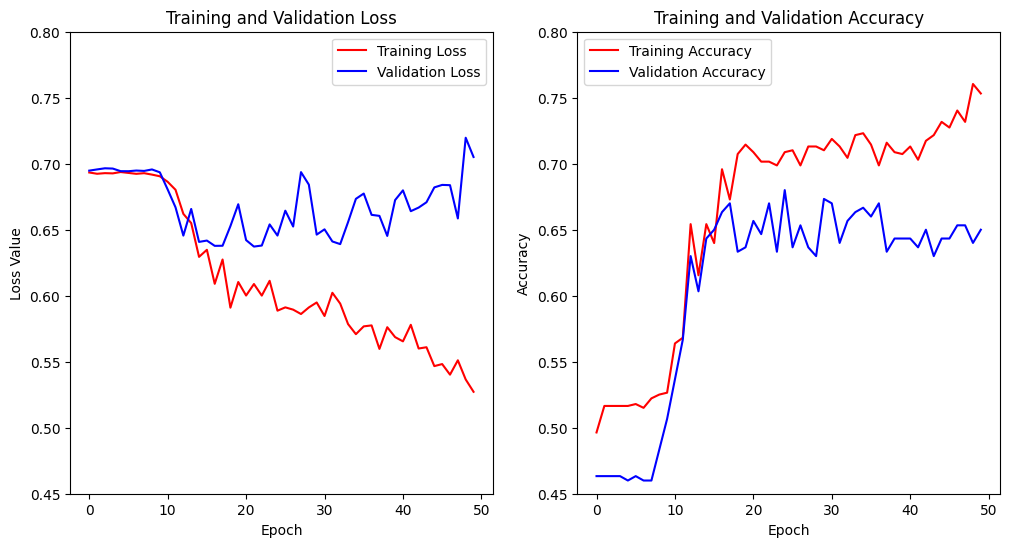

In [53]:
import matplotlib.pyplot as plt

trainLoss = model_history.history["loss"]
valLoss = model_history.history["val_loss"]
trainAccuracy = model_history.history["accuracy"]
valAccuracy = model_history.history["val_accuracy"]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(trainLoss, "r",label="Training Loss")
plt.plot(valLoss, "b", label="Validation Loss")
plt.ylim(0.45,0.80)
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(trainAccuracy, "r",label="Training Accuracy")
plt.plot(valAccuracy, "b", label="Validation Accuracy")
plt.ylim(0.45,0.80)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

10/10 [==============================] - 1s 4ms/step


Text(0.5, 1.0, 'ROC Curve')

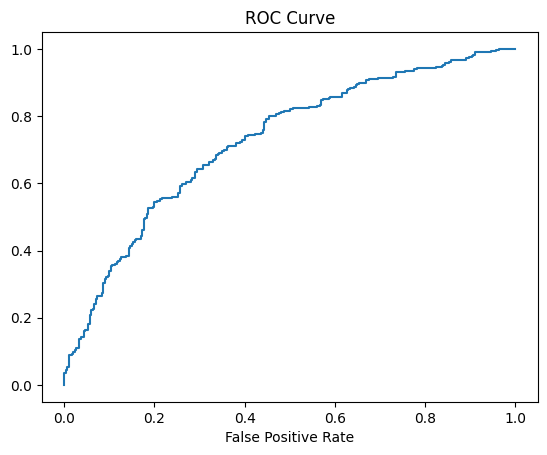

In [31]:
from sklearn.metrics import roc_curve

yPred = model.predict(xTest)

fpr, tpr, thresholds = roc_curve(yTest.ravel(),yPred.ravel())
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")